# A Julia based solution to Jack's Car Rental Problem
### from Reinforcement Learning: An Introduction (Sutton and Barto)

In [52]:
# import Pkg; Pkg.add("OffsetArrays")

The problem as it appears in the book:

Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.
If Jack has a car available, he rents it out and is credited \$10 by the national company.
If he is out of cars at that location, then the business is lost. Cars become available for
renting the day after they are returned. To help ensure that cars are available where
they are needed, Jack can move them between the two locations overnight, at a cost of
\$2 per car moved. We assume that the number of cars requested and returned at each
location are Poisson random variables, meaning that the probability that the number is
n is $ \frac{\lambda^n}{n!} e^-\lambda $, where $\lambda$ is the expected number. Suppose $\lambda$ is 3 and 4 for rental requests at n!
the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma$ = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

For the sake of clarity, the two locations Jack manages will be referred to as $i$ and $j$

$0≤S_i≤20$ where $S_i$ be the number of cars at location $i$, 

$0≤S_j≤20$ where $S_j$ be the number of cars at location $j$

The state $S$ can then be framed as the set $\{S_i, S_j\}$

The action $a$ is the number of cars moved from $i$ to $j$ 

$A = \{-5, -4, .., 5\}$ is the set of all possible actions, or the action space

$A(s) $ is the action space of state $S$, discussed further below


OffsetArrays has been used extensively throughout this problem to override Julia's 1-based indexing, in favour of 0-based indexing for state spaces, and -5-based for action spaces. This makes referring to them super simple, since the index of the array corresponds to the state/action.

In [53]:
using OffsetArrays, Plots

γ = 0.9

tolerance = 0.0001

state_space = (0:20, 0:20)

action_space = -5:5

-5:5

Not all actions are available for each state. For example if Location i has 20 cars, $A(s) ≥ 0$, since no cars can be moved from j to i. Mathematically, $A(s)$ can be calculated from the below equation
 
$ -1 * min(20 - S_i, S_j, 5) ≤ A(s) ≤ min(S_i, 20 - S_j, 5) $

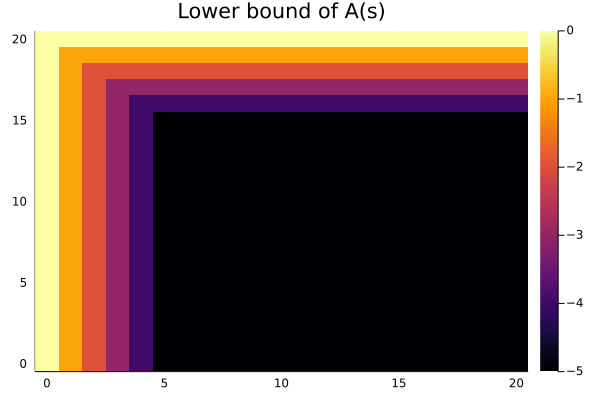

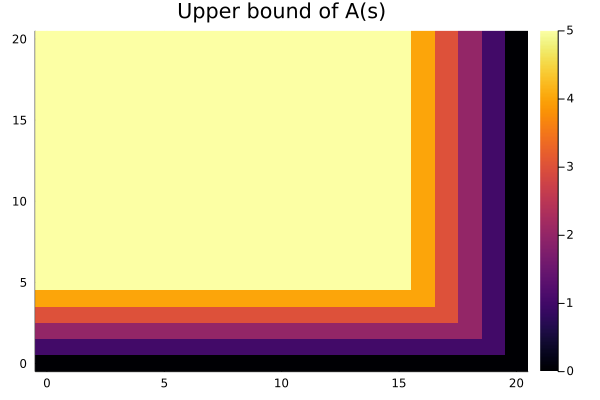

In [54]:
action_state_space = OffsetArray(hcat([[-1*min(20 - i, j, 5):min(i, 20 - j, 5) for i in 0:20] for j in 0:20]...), 0:20, 0:20)

display(plot(heatmap(0:20, 0:20, minimum.(action_state_space), title = "Lower bound of A(s)")))
display(plot(heatmap(0:20, 0:20, maximum.(action_state_space), title = "Upper bound of A(s)")))

The probability distribution of the number of requests/returns at a location are given by the Poisson Distribution:

$ \frac{\lambda^n}{n!} e^-\lambda $

Where $n$ is the number of requests/returns and $\lambda$ is the expected number of requests/returns. 

For this problem $\lambda$ is set to 3 for both requests and returns for location i, and is set to 4 and 2 for requests and returns at location j respectively:

$\lambda_{Ni} = 3$ where $N_i$ is the number of return requests at location $i$ \
$\lambda_{Mi} = 3$ where $M_i$ is the number of rental requests at location $i$ \
$\lambda_{Nj} = 4$ where $N_j$ is the number of return requests at location $j$ \
$\lambda_{Mj} = 2$ where $M_j$ is the number of rental requests at location $j$

The total number of returns and requests, $N_i, M_i, N_j$ and $M_j$, are theoretically only bounded to the set of non negative integers, but to save computation has been limited to {0, 1, ..., 20}. This does not affect our calculations much, since the probabilty of requests and/or requests exceeding 20 is miniscule

To save computation, here we have precalculated and saved the probabilities returned by the poisson distribution for $0 ≤ n ≤ 20$ and $\lambda \in \{2, 3, 4\}$

In [55]:
p_transaction(n, λ) = n ≥ 0 ? (λ^n/factorial(n))ℯ^-λ : 0

# p_transaction_2[i] gives the probability of renting/returning i cars at location with expected rentals/returns 2; 0 ≤ i ≤ 20 
p_transaction_2 = OffsetVector(p_transaction.(0:20, 2), 0:20);
p_transaction_3 = OffsetVector(p_transaction.(0:20, 3), 0:20);
p_transaction_4 = OffsetVector(p_transaction.(0:20, 4), 0:20);

Unfortunately, not all rental and return request can be processed, since the availablilty and capacity of cars is limited. The maximum number of requests and returns that can be processed have been detailed below:

$n_i ≤ 20 - (S_i - a) $ where $n_i$ is the number of acceptable returns at location $i$

$m_i ≤ (S_i - a) + n_i $ where $m_i$ is the number of acceptable requests at location $i$

$n_j ≤ 20 - (S_j + a) $ where $n_j$ is the number of acceptable returns at location $j$

$m_j ≤ (S_j + a) + n_j $ where $m_j$ is the number of acceptable requests at location $j$

To make any progress on this problem however, a mapping is needed between $N_i$ and $n_i$, $M_i$ and $m_i$, $N_j$ and $n_j$ and $M_j$ and $m_j$, since the probability distribution we have is dependent on $N_i, M_i, N_j$ and $M_j$, but the state transitions will depend on $n_i, m_i, n_j$ and $m_j$. Such a mapping is developed below

$n_i = \{^{20 - (S_i - a)  \quad if N_i ≥ 20 - (S_i - a)} _{N_i \qquad \qquad \qquad \quad else}\}$

$m_i = \{^{(S_i - a) + n_i  \quad if N_i ≥ (S_i - a) + n_i} _{M_i \qquad \qquad \qquad \quad else}\}$

$n_j = \{^{20 - (S_j + a)  \quad if N_i ≥ 20 - (S_j + a)} _{N_j \qquad \qquad \qquad \quad else}\}$

$m_j = \{^{(S_j + a) + n_j  \quad if N_j ≥ (S_j + a) + n_j} _{M_j \qquad \qquad \qquad \quad else}\}$

From here we can formulate the transition model of the Markov Decision Process as:

$p(S_{t+1} = i - a + (n_i - m_i), j + a + (n_j - m_j) \ | \ S_t = i, j, A_t = a) = \sum_{i=0} ^{20} \sum_{j=0} ^{20} \frac{\lambda^{N_i}_{N_i}}{N_i!} e^-\lambda * \frac{\lambda^{M_i}_{M_i}}{M_i!} e^-\lambda * \frac{\lambda^{N_j}_{N_j}}{N_j!} e^-\lambda * \frac{\lambda^{M_j}_{M_j}}{M_j!} e^-\lambda$

and the Reward model as

$r(s, a) = -2 * |a| +  \sum_{i=0} ^{20} \sum_{j=0} ^{20} \frac{\lambda^{N_i}_{N_i}}{N_i!} e^-\lambda * \frac{\lambda^{M_i}_{M_i}}{M_i!} e^-\lambda * \frac{\lambda^{N_j}_{N_j}}{N_j!} e^-\lambda * \frac{\lambda^{M_j}_{M_j}}{M_j!} e^-\lambda * (10 * m_i + 10 * n_i)$

where $r(s, a) = E[R_{t+1} \ | \ S_t = i, j, A_t = a] $

In [56]:
function generate_model(state_space, action_space, γ, p_transaction_2, p_transaction_3, p_transaction_4)

    # ssi is 0:20, ssj is 0:20, and as is -5:5 for this problem
    ssi, ssj, as = state_space[1], state_space[2], action_space
    # n_ssi is 21, n_ssj is 21, n_as is 11 for this problem
    n_ssi, n_ssj, n_as = length(ssi), length(ssj), length(as)

    pssa = OffsetArray(zeros(n_ssi, n_ssj, n_ssi, n_ssj, n_as), ssi, ssj, ssi, ssj, as)

    r = OffsetArray(fill(NaN, 21, 21, 11), 0:20, 0:20, -5:5)
    for i in 0:20
        for j in 0:20
            for k in action_state_space[i, j]
                r[i, j, k] = -2*abs(k)
            end
        end
    end
    
    for i in ssi
        # display("Generating model: $(i*5)% complete")
        for j in ssj
            for a in -1*min(20 - i, j, 5):min(i, 20 - j, 5)

                for Ni in 0:length(p_transaction_3) - 1
                    ni = Ni ≥ 20 - (i - a) ? 20 - (i - a) : Ni

                    for Mi in 0:length(p_transaction_3) - 1
                        mi = Mi ≥ (i - a) + ni ? (i - a) + ni : Mi
                
                        for Nj in 0:length(p_transaction_2) - 1
                            nj = Nj ≥ 20 - (j + a) ? 20 - (j + a) : Nj

                            for Mj in 0:length(p_transaction_4) - 1
                                mj = Mj ≥ (j + a) + nj ? (j + a) + nj : Mj

                                p_temp = p_transaction_3[Ni] * p_transaction_3[Mi] * p_transaction_2[Nj] * p_transaction_4[Mj]
                                pssa[i - a + (ni-mi), j + a + (nj-mj), i, j, a] += p_temp 
                                r[i, j, a] += p_temp * (10 * mi + 10 * mj)
                            end
                        end
                    end
                end
            end
        end
    end
    return pssa, r
end

generate_model (generic function with 1 method)

To evaluate a Policy $π$, dynamic programming is used. Specifically, Bellman backup is utilised to iteratively calculate the value function of the policy, starting with a value of zero.

$V^π_k(s) = r(s, π(s)) + \gamma \sum_{ś \in S}p(ś | s, π(s))V^π_{k-1}(ś)$

In [57]:
function evaluate_policy(state_space, policy, tolerance, pssa, r, γ)

    # Initial v
    v = OffsetArray(zeros(21, 21), 0:20, 0:20)

    while true
        vsum_old = sum(v)
        for si in state_space[1]
            for sj in state_space[2]
                v_new = r[si, sj, policy[si, sj]] + γ * sum(pssa[:, :, si, sj, policy[si, sj]] .* v)
                v[si, sj] = v_new
            end
        end
        vsum_new = sum(v)
        if vsum_new - vsum_old < tolerance
            println("Value: $(vsum_new)")
            return v
        end
    end
end

evaluate_policy (generic function with 1 method)

To Improve our Policy, Policy Iteration is utilised where the value of taking the best greedy action and thereafter following the old policy is compared with the value of just following the old policy. If the value of the best greedy action and follwing the old policy thereafter is greater than just following the old policy, the greedy action is guaranteed to be better than the old policy, and the policy is updated.

$Q^{π_i}(s, a) = R(s, a) + \gamma \sum_{ś \in S}p(ś | s, π(s))V^{π_i}(ś)$

$max_a Q^{π_i}(s, a) ≥ V^{π_i}(s)$

$π_{i+1}(s) = argmax_a Q^{π_i}(s, a)$

This algorithm is run until the policy stops improving. This is the optimal policy $π^*$

In [58]:
function improve_policy(state_space, action_state_space, policy, policy_value, pssa, r, γ,)
    optimal_policy = true
    for si in state_space[1]
        for sj in state_space[2]
            actions, action_values = [], []
            for action in action_state_space[si, sj]
                action_value = r[si, sj, action] + γ * sum(pssa[:, :, si, sj, policy[si, sj]] .* policy_value)
                push!(actions, action)
                push!(action_values, action_value)
            end
            optimal_action, optimal_action_value = actions[findmax(action_values)[2]], findmax(action_values)[1]
            if (optimal_action != policy[si, sj]) & (optimal_action_value > policy_value[si, sj])
                optimal_policy = false
                # println("State: $((si, sj)), optimal_action: $(optimal_action), policy_action: $(policy[si, sj]) 
                # optimal_action_value: $(optimal_action_value), policy_value: $(policy_value[si, sj])")
                policy[si, sj] = optimal_action
            end
        end
    end
    return policy, optimal_policy    
end

improve_policy (generic function with 1 method)

In [59]:
pssa, r = generate_model(state_space, action_space, γ, p_transaction_2, p_transaction_3, p_transaction_4);

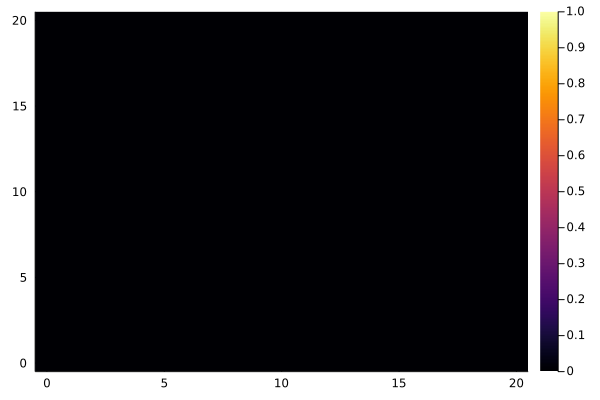

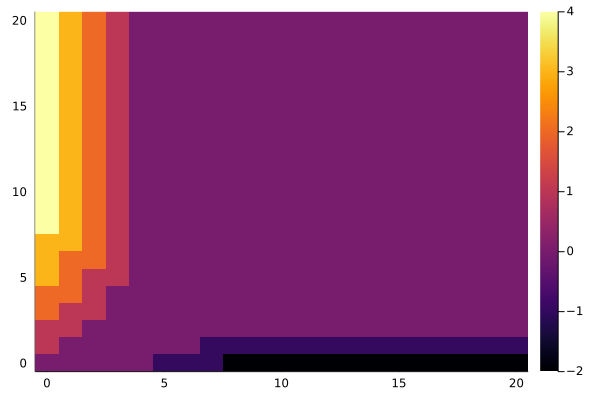

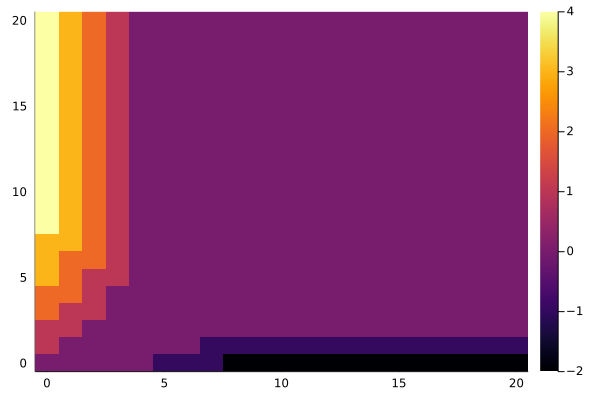

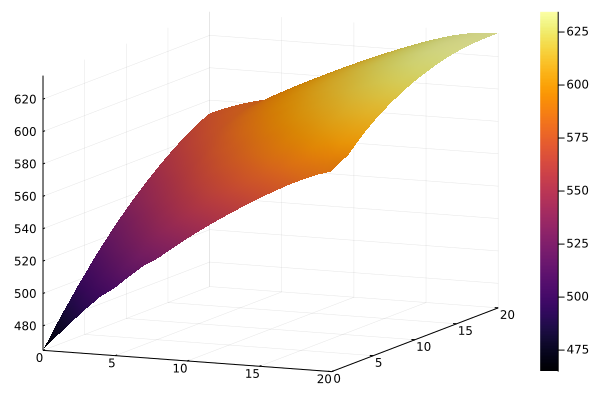

Value: 245058.98269191987
Value: 256876.05396426888
Value: 256876.05396426888


In [60]:
# intial policy
policy = OffsetArray(Int.(zeros(21, 21)), 0:20, 0:20)
optimal = false

policies = []
push!(policies, policy)

while !optimal
    policy_value = evaluate_policy(state_space, policy, tolerance, pssa, r, γ)
    policy, optimal = improve_policy(state_space, action_state_space, copy(policy), policy_value, pssa, r, γ)
    push!(policies, policy)
end
policy_value = evaluate_policy(state_space, policy, tolerance, pssa, r, γ)

for policy in policies
    display(plot(heatmap(0:20, 0:20, policy)))
end

display(plot(surface(0:20, 0:20, policy_value)))

The resulting policy and number of iterations required to reach that policy reached here seems to be slightly different from that in the book. It is unclear at this stage why this is the case. (Please do reach out if you think you know where the problem lies!) 